# Binary Classification with a Bank Churn

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, make_scorer, roc_curve
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from skopt import BayesSearchCV
from tqdm import tqdm


In [320]:
df = pd.read_csv(r"train.csv")
df

id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0    15674932  Okwudilichukwu          668    France    Male   
1            1    15749177   Okwudiliolisa          627    France    Male   
2            2    15694510           Hsueh          678    France    Male   
3            3    15741417             Kao          581    France    Male   
4            4    15766172       Chiemenam          716     Spain    Male   
...        ...         ...             ...          ...       ...     ...   
165029  165029    15667085            Meng          667     Spain  Female   
165030  165030    15665521       Okechukwu          792    France    Male   
165031  165031    15664752            Hsia          565    France    Male   
165032  165032    15689614          Hsiung          554     Spain  Female   
165033  165033    15732798         Ulyanov          850    France    Male   

         Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       33.0       3       0.00              2        1.0             0.0   
1       33.0       1       0.00              2        1.0             1.0   
2       40.0      10       0.00              2        1.0             0.0   
3       34.0       2  148882.54              1        1.0             1.0   
4       33.0       5       0.00              2        1.0             1.0   
...      ...     ...        ...            ...        ...             ...   
165029  33.0       2       0.00              1        1.0             1.0   
165030  35.0       3       0.00              1        0.0             0.0   
165031  31.0       5       0.00              1        1.0             1.0   
165032  30.0       7  161533.00              1        0.0             1.0   
165033  31.0       1       0.00              1        1.0             0.0   

        EstimatedSalary  Exited  
0             181449.97       0  
1              49503.50       0  
2             184866.69       0  
3              84560.88       0  
4              15068.83       0  
...                 ...     ...  
165029        131834.75       0  
165030        131834.45       0  
165031        127429.56       0  
165032         71173.03       0  
165033         61581.79       1  

[165034 rows x 14 columns]

In [321]:
column_types = df.dtypes
column_types

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [322]:
df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Filling missing

In [323]:
# Fill in missing values as specified
df['Geography'].fillna('unknown', inplace=True)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['HasCrCard'].fillna(df['HasCrCard'].mode()[0], inplace=True)  # mode() returns a Series
df['IsActiveMember'].fillna(df['IsActiveMember'].mode()[0], inplace=True)

# Verify the changes
missing_values = df.isnull().sum()
missing_values

C:\Users\shin7\AppData\Local\Temp\ipykernel_33848\990490740.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\shin7\AppData\Local\Temp\ipykernel_33848\990490740.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# Exploratory Data Analysis

#### Bot plot

In [324]:
# This setup allows for six plots to be displayed in a structured format.
fig = make_subplots(rows=2, cols=3)

#The add_trace function is used to add individual box plots for different variables
fig.add_trace(go.Box(y=df['CreditScore'], name='CreditScore'), row=1, col=1)
fig.add_trace(go.Box(y=df['Age'], name='Age'), row=1, col=2)
fig.add_trace(go.Box(y=df['Tenure'], name='Tenure'), row=1, col=3)
fig.add_trace(go.Box(y=df['Balance'], name='Age'), row=2, col=1)
fig.add_trace(go.Box(y=df['NumOfProducts'], name='NumOfProducts'), row=2, col=2)
fig.add_trace(go.Box(y=df['EstimatedSalary'], name='EstimatedSalary'), row=2, col=3)
fig.update_layout(height=900, width=1500, title_text="Box Plots with Different Y-Axis Units")
fig.show()


#### Scatter plot

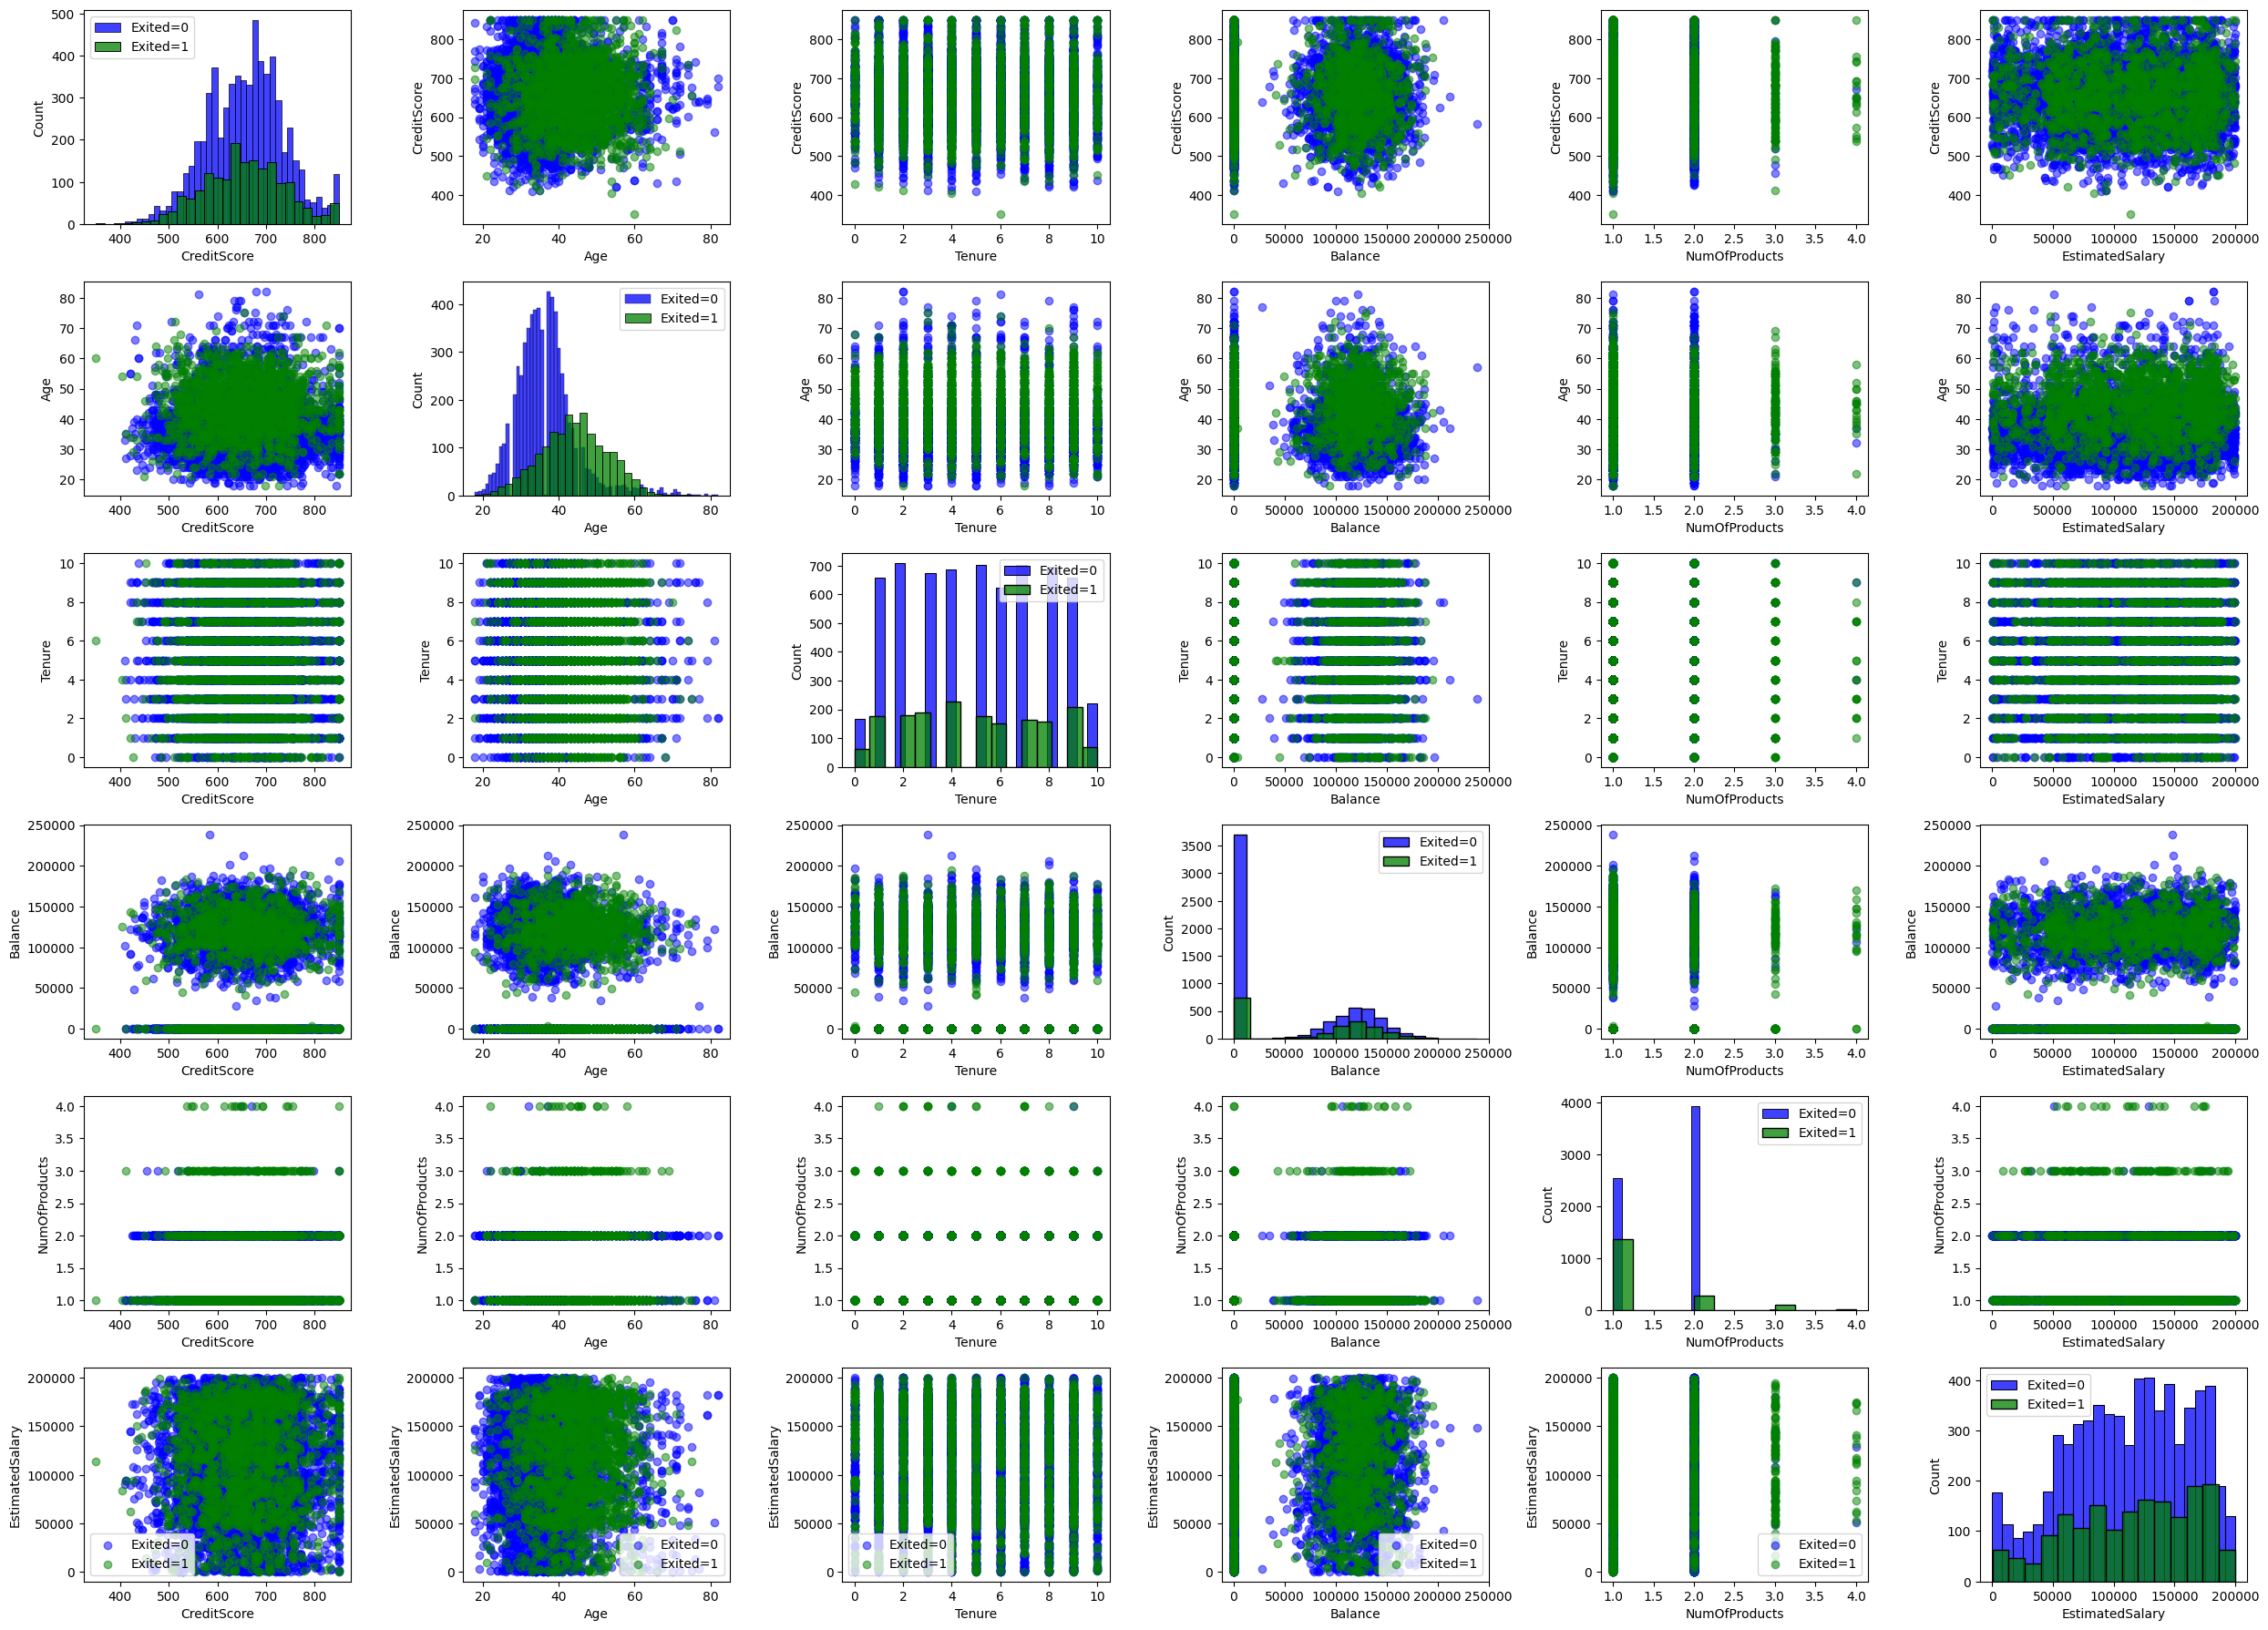

In [325]:
#Scatter plots are useful for identifying relationships between variables, spotting outliers, and revealing data clusters and patterns.
sampled_df = df.sample(frac=0.05)
dimensions=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Set the size of the figure
plt.figure(figsize=(25, 18))

# Set colors, 0: blue, 1: green
colors = {0: 'blue', 1: 'green'}

# Calculate the number of dimensions
n = len(dimensions)

# Iterate over each pair of dimensions
for i in range(n):
    for j in range(n):
        plt.subplot(n, n, i * n + j + 1)
        
        # Plot histograms on the diagonal
        if i == j:
            # Plot histograms for each unique value of 'Exited'
            for value in [0, 1]:
                sns.histplot(sampled_df[sampled_df['Exited'] == value][dimensions[i]], color=colors[value], label=f'Exited={value}', kde=False)
            plt.legend()
        
        # Plot scatter plots in other positions
        else:
            # Plot scatter plots for each value of 'Exited' separately
            for value in [0, 1]:
                subset = sampled_df[sampled_df['Exited'] == value]
                plt.scatter(subset[dimensions[j]], subset[dimensions[i]], color=colors[value], label=f'Exited={value}', alpha=0.5)
            
            plt.xlabel(dimensions[j])
            plt.ylabel(dimensions[i])
            if i == n-1:  # Only add the legend to the bottom-most plots
                plt.legend()

# Adjust layout
plt.tight_layout()

# feature engineering

#### Adjusting outliers

In [326]:
#Adjusting outliers is crucial to prevent them from skewing the analysis and improving the accuracy and reliability of machine learning models.
for column in dimensions:
    # Calculate the Q1 and Q3 for each specified column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper limits
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    
    # Calculate the mean and standard deviation
    mean = df[column].mean()
    std = df[column].std()
    
    # Adjusting outliers
    df[column] = np.where(df[column] > upper_whisker, mean + 5*std, df[column])
    df[column] = np.where(df[column] < lower_whisker, mean - 5*std, df[column])

#### Fix Skewness

In [327]:
# Fixing skewness improves model performance by creating a more uniform data distribution.
for column in dimensions:
    skewness = df[column].skew()
    # If skewness is greater than 1 or less than -1, perform log transformation
    if abs(skewness) > 1:
        # Use np.log1p for log transformation to handle zero and negative values gracefully
        # np.log1p(x) calculates log(x + 1), avoiding issues with log(0)
        df[column + '_log'] = np.log1p(df[column])

#### One-Hot Encoding & train_test_split

In [328]:
# OHE (One-Hot Encoding) converts categorical data into numerical format, enhancing model interpretability and performance.
# One-hot encode 'Geography' and 'Gender' columns
df_encoded = pd.get_dummies(df, columns=['Geography', 'Gender'])
df = df_encoded

# Drop irrelevant columns and sample a fraction of the data
df = df.drop(columns=['id', 'CustomerId', 'Surname'])
y = df['Exited']
X = df.drop(['Exited'], axis=1)


## Feature Selection

In [329]:
def forward_feature_selection(X, y, max_features=None, patience=3):
    # Initialize the list of all features and selected features
    features = list(X.columns)
    selected_features = []
    best_score = 0
    no_improvement_count = 0
    performance_history = []
    
    # Determine the maximum number of iterations based on available features
    max_iterations = len(features) if max_features is None else min(len(features), max_features)
    
    # Initialize the progress bar
    pbar = tqdm(total=max_iterations, desc="Feature Selection Progress")
    
    # Start feature selection process
    while features and (max_features is None or len(selected_features) < max_features):
        best_new_score = 0
        best_feature = None
        
        # Evaluate each remaining feature
        for feature in features:
            current_features = selected_features + [feature]
            model = LGBMClassifier(random_state=42)
            scores = cross_val_score(model, X[current_features], y, cv=5, scoring='f1')
            score = np.mean(scores)
            
            # Update the best feature and score if the current score is better
            if score > best_new_score:
                best_new_score = score
                best_feature = feature
        
        # If the best score improves, add the feature to selected features
        if best_new_score > best_score:
            selected_features.append(best_feature)
            features.remove(best_feature)
            best_score = best_new_score
            no_improvement_count = 0
            performance_history.append((len(selected_features), best_score))
            pbar.set_postfix({"Best f1": f"{best_score:.4f}", "Features": len(selected_features)})
            pbar.update(1)
        else:
            no_improvement_count += 1
        
        # Stop if no improvement after a number of iterations (patience)
        if no_improvement_count >= patience:
            pbar.set_postfix({"Status": "Early stopping"})
            break
    
    pbar.close()
    return selected_features, performance_history


#### Illustrate the line chart to find the relationship between feature and performance

Feature Selection Progress:   0%|          | 0/14 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 1
[LightGBM] [Info] 

Feature Selection Progress:   7%|▋         | 1/14 [00:12<02:47, 12.92s/it, Best f1=0.4039, Features=1]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Feature Selection Progress:  14%|█▍        | 2/14 [00:28<02:54, 14.55s/it, Best f1=0.5735, Features=2]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 301
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 3
[LightGBM] [Info] 

Feature Selection Progress:  21%|██▏       | 3/14 [00:43<02:40, 14.63s/it, Best f1=0.5792, Features=3]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 302
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 4
[LightGBM] [Info] 

Feature Selection Progress:  29%|██▊       | 4/14 [00:57<02:26, 14.62s/it, Best f1=0.5960, Features=4]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 5
[LightGBM] [Info] 

Feature Selection Progress:  36%|███▌      | 5/14 [01:11<02:09, 14.36s/it, Best f1=0.6106, Features=5]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 6
[LightGBM] [Info] 

Feature Selection Progress:  43%|████▎     | 6/14 [01:24<01:51, 13.94s/it, Best f1=0.6315, Features=6]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 7
[LightGBM] [Info] 

Feature Selection Progress:  50%|█████     | 7/14 [01:37<01:33, 13.34s/it, Best f1=0.6354, Features=7]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[L

Feature Selection Progress:  57%|█████▋    | 8/14 [01:48<01:16, 12.76s/it, Best f1=0.6366, Features=8]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 9
[LightGBM] [Info] 

Feature Selection Progress:  64%|██████▍   | 9/14 [01:58<00:59, 11.97s/it, Best f1=0.6367, Features=9]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 10
[LightGBM] [Info

Feature Selection Progress:  71%|███████▏  | 10/14 [02:07<00:44, 11.05s/it, Best f1=0.6370, Features=10]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info

Feature Selection Progress:  79%|███████▊  | 11/14 [02:15<00:29,  9.96s/it, Best f1=0.6374, Features=11]

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 12
[LightGBM] [Info

Feature Selection Progress:  79%|███████▊  | 11/14 [02:31<00:41, 13.81s/it, Status=Early stopping]      

Final selected features:
['Age', 'NumOfProducts', 'IsActiveMember', 'Gender_Female', 'Geography_Germany', 'Balance', 'EstimatedSalary', 'CreditScore', 'Tenure', 'Geography_Spain', 'Geography_France']


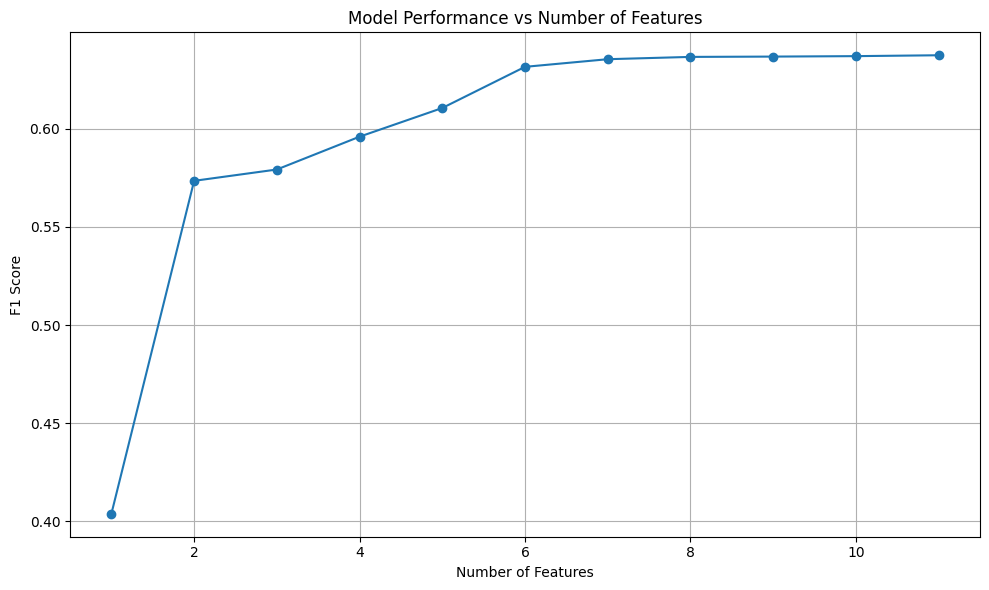

In [330]:
selected_features, performance_history = forward_feature_selection(X, y, patience=3)

print("Final selected features:")
print(selected_features)

feature_counts, f1_scores = zip(*performance_history)

plt.figure(figsize=(10, 6))
plt.plot(feature_counts, f1_scores, marker='o')
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter tuning

In [331]:
X = df[selected_features]  # Only use the selected features
y = df['Exited']  # Target variable

# Split the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
lgbm = LGBMClassifier(
    class_weight='balanced',  # Automatically adjust weights based on class frequency
    scale_pos_weight=5,  # Or manually set weight ratio, e.g., negative:positive ratio
    random_state=42
)

# Define the parameter space for Bayesian search
param_space = {
    'num_leaves': (15, 50),  
    'min_child_samples': (5, 30),
    'max_depth': (2, 6),
    'learning_rate': (0.005, 0.05, 'log-uniform'),
    'n_estimators': (50, 300),
    'subsample': (0.8, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 0.8, 'uniform'),
    'scale_pos_weight': (7, 11)
}

# Initialize tqdm progress bar
progress_bar = tqdm(total=100)

# Define a callback function to update the progress bar
def on_step(optim_result):
    progress_bar.update(1)

# Define Bayesian search and pass the progress bar callback
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    n_iter=100,
    verbose=0,
    random_state=42
)

# Add the progress bar callback
bayes_search.fit(X_train, y_train, callback=on_step)

# Close the progress bar
progress_bar.close()

# Output the best parameters
print("Best parameters found: ", bayes_search.best_params_)
print("Best F1 score: ", bayes_search.best_score_)

100%|██████████| 100/100 [07:17<00:00,  5.73s/it]

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 100/100 [07:18<00:00,  4.39s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found:  OrderedDict([('colsample_bytree', 0.8), ('learning_rate', 0.049999999999999996), ('max_depth', 6), ('min_child_samples', 14), ('n_estimators', 300), ('

In [332]:
best_lgbm = LGBMClassifier(**bayes_search.best_params_, random_state=42)
best_lgbm.fit(X_train, y_train)
y_pred = best_lgbm.predict(X)

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [333]:
# classification_report
print("\nTraining set Classification Report:")
print(classification_report(y, y_pred))

# confusion_matrix
print("\nValidation set Confusion Matrix:")
print(confusion_matrix(y, y_pred))


Training set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    130113
           1       0.46      0.90      0.60     34921

    accuracy                           0.75    165034
   macro avg       0.71      0.80      0.71    165034
weighted avg       0.86      0.75      0.77    165034


Validation set Confusion Matrix:
[[92666 37447]
 [ 3606 31315]]


## ROC-AUC

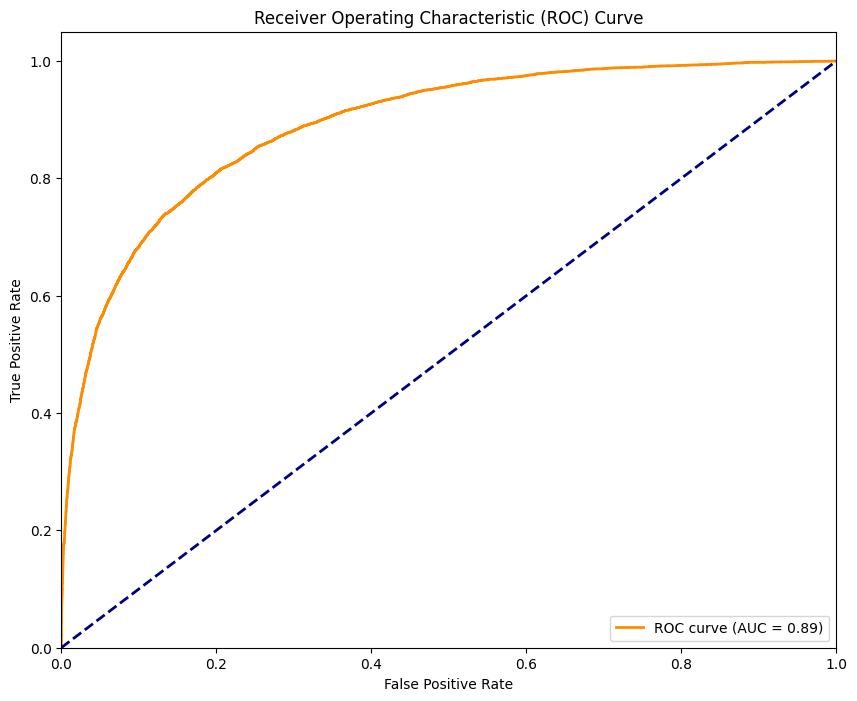

AUC-ROC score: 0.8896


In [334]:
y_pred_proba = best_lgbm.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC score: {roc_auc:.4f}")